# Сборный проект

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Не важно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import factorial
from scipy import stats as st
from scipy.stats import ttest_ind
import seaborn as sns

# Шаг 1. Откройте файл с данными и изучите общую информацию

Данные о играх находятся в файле '/datasets/games.csv'. Откроем его.

In [2]:
games = pd.read_csv('/datasets/games.csv')
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В колонке 'User_Score' тип данных object. Заменим его на float.

В колонках 'Name', 'Year_of_Release', 'Genre', 'Critic_Score', 'User_Score' и 'Rating' есть пропуски. В 'Name' и 'Genre' их по два (возможно есть связь).

Также названия колонок начинаются с загланой буквы. С ними очень неудобно работать. Нужно будет перевести в нижний регистр.

Определим количество пропусков в процентах.

In [4]:
percent_missing = games.isnull().sum() * 100 / len(games)
missing_value_games = pd.DataFrame({'column_name': games.columns,
                                 'percent_missing': percent_missing})
missing_value_games

,column_name,percent_missing
Name,Name,0.011965
Platform,Platform,0.000000
Year_of_Release,Year_of_Release,1.609333
Genre,Genre,0.011965
NA_sales,NA_sales,0.000000
EU_sales,EU_sales,0.000000
JP_sales,JP_sales,0.000000
Other_sales,Other_sales,0.000000
Critic_Score,Critic_Score,51.319174
User_Score,User_Score,40.089740


Самое большое количество пропусков в трёх колонках:

- Critic_Score - 51%
- User_Score - 40%
- Rating - 40%

###### Вывод 1

Осмотрев данны мы нашли следующие ошибки:
- В колонке 'User_Score' тип данных object. Заменим его на float.
- В колонках 'Name', 'Year_of_Release', 'Genre', 'Critic_Score', 'User_Score' и 'Rating' есть пропуски. В 'Name' и 'Genre' их по два (возможно есть связь).
- Названия колонок начинаются с загланой буквы. С ними очень неудобно работать. Нужно будет перевести в нижний регистр.]

# Шаг 2. Подготовьте данные

<font color=#008000> 2.1 Перевод названий колонок в нижний регистр </font>

Переведём названия колонок в нижний регистр с помощью метода .str.lower().

In [5]:
games.columns = games.columns.str.lower()

<font color=#008000> 2.2 Преобразование данных в нужные типы </font>

Нам нужно произвести следующие действия:
- перевести данные в 'user_score' из object в float.

Из условия мы знаем, что в этой колонке есть странное значение - tbd. Посмотрим на него.

In [6]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [7]:
games.query('user_score == "tbd"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001.0,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003.0,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008.0,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008.0,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


Из FAQ сайта Metacritic мы узнали, что абреавиатура tbd переводится как 'To Be Determined'. Она означает, что у игры меньше 4х ревью, и ей невозможно поставить объективную оценку. Это могло произойти с непопулярными, или очень нишевыми играми. Их аудитория очень мала, и не все игроки удосуживаются поставить оценку игре.

Наш вердикт - tbd = NaN.

Определить значение для заполнения мы не можем, а удаление этих значений было бы расточительством, ведь в этих строках есть данные по продажам и жанрам. Поэтому мы заменим значения tbd на 'NaN'.

In [8]:
games['user_score'] = games['user_score'].replace('tbd', np.NaN)

Теперь переведём 'user_score' из object в float.

In [9]:
games['user_score'] = games['user_score'].astype('float')

<font color=#008000> 2.3 Обработка пропусков</font>

In [10]:
percent_missing = games.isnull().sum() * 100 / len(games)
missing_value_games = pd.DataFrame({'column_name': games.columns,
                                 'percent_missing': percent_missing})
missing_value_games

,column_name,percent_missing
name,name,0.011965
platform,platform,0.000000
year_of_release,year_of_release,1.609333
genre,genre,0.011965
na_sales,na_sales,0.000000
eu_sales,eu_sales,0.000000
jp_sales,jp_sales,0.000000
other_sales,other_sales,0.000000
critic_score,critic_score,51.319174
user_score,user_score,54.591684


У нас есть пропуски в следующих колонках:
- 'name'
- 'year_of_release'
- 'genre'
- 'critic_score'
- 'user_score'
- 'rating'

В 'name' и 'genre' их всего два. Посмотрим на них.

In [11]:
games.query('name != name and genre != genre')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Две игры, вышедшие на Sega Genesis в 1993 году, и по которым у нас нет данных по жанру, оценкам критиков/пользователей, и рейтингу. Их можно только удалить.

In [12]:
games = games.drop([659, 14244])

In [13]:
games.query('name != name and genre != genre')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Теперь 'critic_score' и 'user_score'. Заполним пропуски в этих колонках значением -1.

In [14]:
games['critic_score'] = games['critic_score'].fillna(-1)
games['user_score'] = games['user_score'].fillna(-1)

Теперь к пропускам в 'year_of_release'. В названиях некоторых игр есть год выпуска, как например в Fifa 2016. Можно было бы провести лемматизацию, и вытащить эти годы из названий игр. Но год в названии не всегда совпадает с годом выпуска, и на некоторых платформах игра с этим же названием могла выйти позже. Поэтому считаю, что лучше оставить пропуски в этой колонке как есть.

И наконец 'rating'. ESRB была основана в 1993 году. Может быть пропуски есть только у игр, вышедших до этого?

In [15]:
games.query('year_of_release < 1993 and rating != rating')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,-1.0,-1.0,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,-1.0,-1.0,NaN
18,Super Mario World,SNES,1990.0,Platform,12.78,3.75,3.54,0.55,-1.0,-1.0,NaN
21,Super Mario Land,GB,1989.0,Platform,10.83,2.71,4.18,0.42,-1.0,-1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
12726,Teenage Mutant Ninja Turtles: Tournament Fighters,SNES,1992.0,Fighting,0.00,0.00,0.06,0.00,-1.0,-1.0,NaN
13064,Lagoon,SNES,1991.0,Role-Playing,0.00,0.00,0.05,0.00,-1.0,-1.0,NaN
13571,Sonic the Hedgehog 2 (8-bit),GG,1992.0,Platform,0.00,0.00,0.04,0.00,-1.0,-1.0,NaN
15692,Empire Deluxe,PC,1992.0,Strategy,0.02,0.00,0.00,0.00,-1.0,-1.0,NaN


Только у 301 игра имеет пропуски в этой колонке. Заполнить пропуски в этой колонке средним у нас точно не получится, поэтосу оставлю пропуски как есть.

In [16]:
percent_missing = games.isnull().sum() * 100 / len(games)
missing_value_games = pd.DataFrame({'column_name': games.columns,
                                 'percent_missing': percent_missing})
missing_value_games

,column_name,percent_missing
name,name,0.000000
platform,platform,0.000000
year_of_release,year_of_release,1.609526
genre,genre,0.000000
na_sales,na_sales,0.000000
eu_sales,eu_sales,0.000000
jp_sales,jp_sales,0.000000
other_sales,other_sales,0.000000
critic_score,critic_score,0.000000
user_score,user_score,0.000000


У нас остались пропуски только в колонке 'year_of_release' и 'rating'.

<font color=#008000> 2.4 Cуммарные продажи во всех регионах</font>

Добавим новую колонку с сумарными продажами по всем регионам.

In [17]:
games['sales_total'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_total
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,NaN,31.38


###### Вывод 2

Мы произвели следующие действия:
- перевели названия колонок в нижний регистр.
- перевели данные в 'user_score' из object в float.
- заменили пропуски в 'critic_score' и 'user_score' на значение -1.
- удалили строчки с пропусками в колонках 'name' и 'genre'.

# Шаг 3. Исследовательский анализ данных

<font color=#008000> 3.1 Сколько игр выпускалось в разные годы</font>

Для начала напишем функцию для постройки диаграмм.

In [18]:
def create_bar(groupby_column, func, y='name'):
    plt.style.use('seaborn-pastel')
    df_to_plot = games.groupby(groupby_column)[y]
    if func == 'count':
        df_to_plot_calculated = df_to_plot.count()
        figsize = (15,5)
        plot = df_to_plot_calculated.plot(kind='bar', y=y, figsize=figsize, ec='black')
    elif func == 'sum':
        df_to_plot_calculated = df_to_plot.sum().sort_values()
        figsize = (15,10)
        plot = df_to_plot_calculated.plot(kind='barh', y=y, figsize=figsize, ec='black')

Теперь применим её для построения графика выпуска игр по годам.

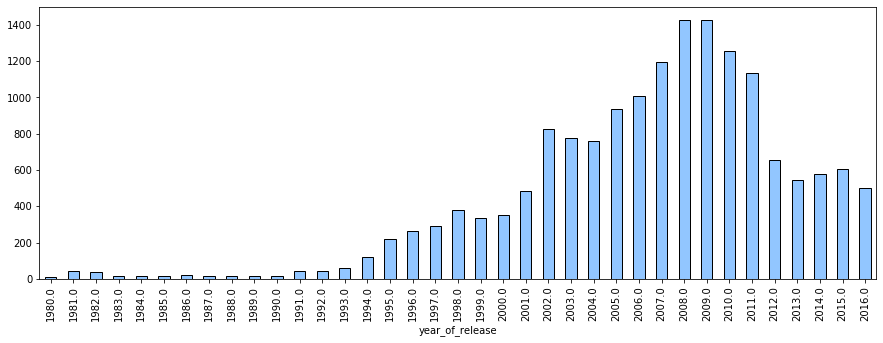

In [19]:
create_bar('year_of_release', 'count')

В 1994 году начался резкий рост количества видеоигр, достигнув пика в период с 2005 до 2011 (период 7го поколения консолей: Xbox 360, PS3, Wii). После 2009 года начался заметный спад, связанный с развитием рынка мобильных видеоигр, за которым последовал огромный провал в 2012 году (конец жизненного цикла седьмого поколения), а в 2013 начался умеренный рост (выход восьмого поколения консолей: Wii U, PS4, Xbox One).

<font color=#008000> 3.2 Как менялись продажи по платформам?</font>

Сначала найдём платформы с наибольшими родажами.

In [20]:
games.groupby('platform')['sales_total'].sum().to_frame('sales_total').sort_values(by='sales_total', ascending=False).head(10)

,sales_total
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12
PS,730.86
GBA,317.85
PS4,314.14
PSP,294.05


Самая большая разница в продажах между соседями у PS и GBA, поэтому будем считать динамику продаж для следующих платформ:
- PS2
- X360
- PS3
- Wii
- DS
- PS

In [21]:
top_sales_platforms = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

Теперь напишем функцию для постройки диаграммы с помощью библиотеки mplcursors.

In [22]:
!pip install mplcursors

In [39]:
import mplcursors

In [40]:
def create_any_lines(platforms=None, query=None):
    %matplotlib notebook
    plt.style.use('tableau-colorblind10') 
    
    ax = plt.gca()
    legend_list = []
    if query == None:
        if platforms == None:
            bbox_y = 1.08
            legend_size = 7
            platforms = games['platform'].unique().tolist()
        else:
            platforms = platforms
            bbox_y = 0.97
            legend_size = 9
    else:
        platforms = games.query(query)['platform'].unique().tolist()
        bbox_y = 0.97
        legend_size = 9
        
    for platform in platforms:
        if query == None:
            df_to_plot = games.query('platform == @platform')
        else:
            df_to_plot = games.query('platform == @platform').query(query)
        lines = df_to_plot.groupby('year_of_release')['sales_total'].sum().plot(x='year_of_release', y='sales_total',
                                                                    style='.-', kind='line', fontsize=10,
                                                                    linewidth=1, label=platform, ax=ax, figsize=(10,5))
        legend_list.append(platform)
    
    ax.set_xlabel('')
   
    ax.legend(legend_list, prop={'size':legend_size}, bbox_to_anchor=(1.0, bbox_y))

    mplcursors.cursor(hover=True).connect("add", lambda sel: sel.annotation.set_text(sel.artist.get_label()))

<IPython.core.display.Javascript object>


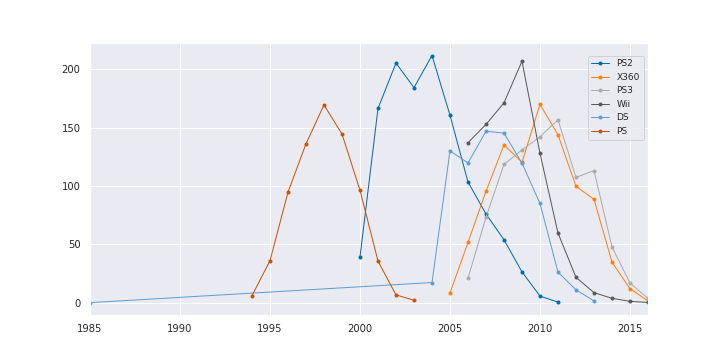

In [43]:
create_any_lines(platforms = top_sales_platforms)

- PS2 - жизненный цикл - 11 лет
- Xbox 360 - жизненный цикл - 10 лет
- PS3 - жизненный цикл - 10 лет
- Wii - жизненный цикл - 10 лет
- DS - Nintendo DS была выпущена в 2004 году, и этот длинный хвост скорее всего является ошибкой в данных. жизненный цикл - 9 лет
- PS - жизненный цикл - 9 лет

Жизненный цикл консоли составляет 9-10 лет.


<font color=#008000> 3.3 Как менялись продажи по платформам в актуальном периоде?</font>

За актуальный период лучше всего выбрать 2005 - 2016 годы, т.к. в 2005 вышло предыдущее, седьмое, поколение консолей: Xbox 360, PS3 и Wii.


<IPython.core.display.Javascript object>


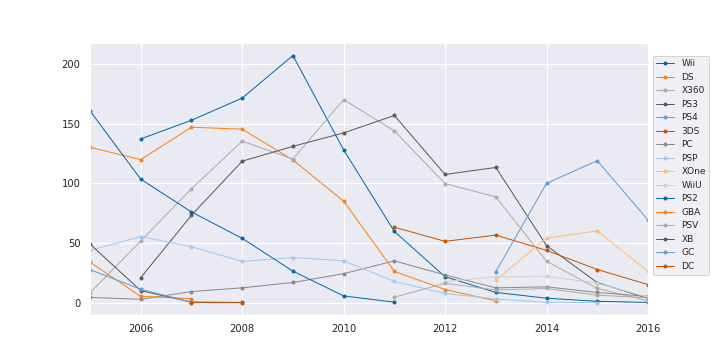

In [42]:
create_any_lines(query = 'year_of_release >= 2005')

График выглядит немного печально: продажи игр падают. В 2016 году лучше всего продавались игры 3х платформ:
- PS4
- Xbox One
- 3DS

Сегоднящний рынок домашних консолей, это противостояние 2х гигантов: Sony (PS4), и Microsoft (Xbox One). Они занимают наибольшую часть рынка. Продажи игр на консолях начинают резко падать только к концу их жизненного цикла (анонс нового поколения). В 2017 выход нового поколения не планируется, так что мы можем предположить, что игры на PS4 и Xbox One будут самыми востребованными.

3DS - портативная консоль, страдающая от роста рынка игр на смартфонах. Продажи продолжат падать.

<font color=#008000> 3.4 График «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам.</font>

Нам нужно построить график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам, определить разницу в продажах, и описать результат.

Напишем функцию для построения 'ящиков с усами'.

In [26]:
def create_any_sales_boxplot(title=None, query_condition = None, ylims=None):
    %matplotlib inline
    if query_condition == None:
        ax = games.boxplot(column='sales_total', fontsize=25, figsize=(25,10), notch=True)
    else:
        df_query = games.query(query_condition)
        by_column = query_condition.split()[0]
        ax = df_query.boxplot(column='sales_total', by=by_column, fontsize=25, figsize=(25,10), notch=True)
        ax.set_xlabel('')
        ax.set_title('')
    if ylims != None:
        ax.set_ylim(ylims)
    if title != None:
        plt.suptitle(title, y=0.94, fontsize=25, fontweight='bold')

Посмотрим нак глобальные продажи игр.

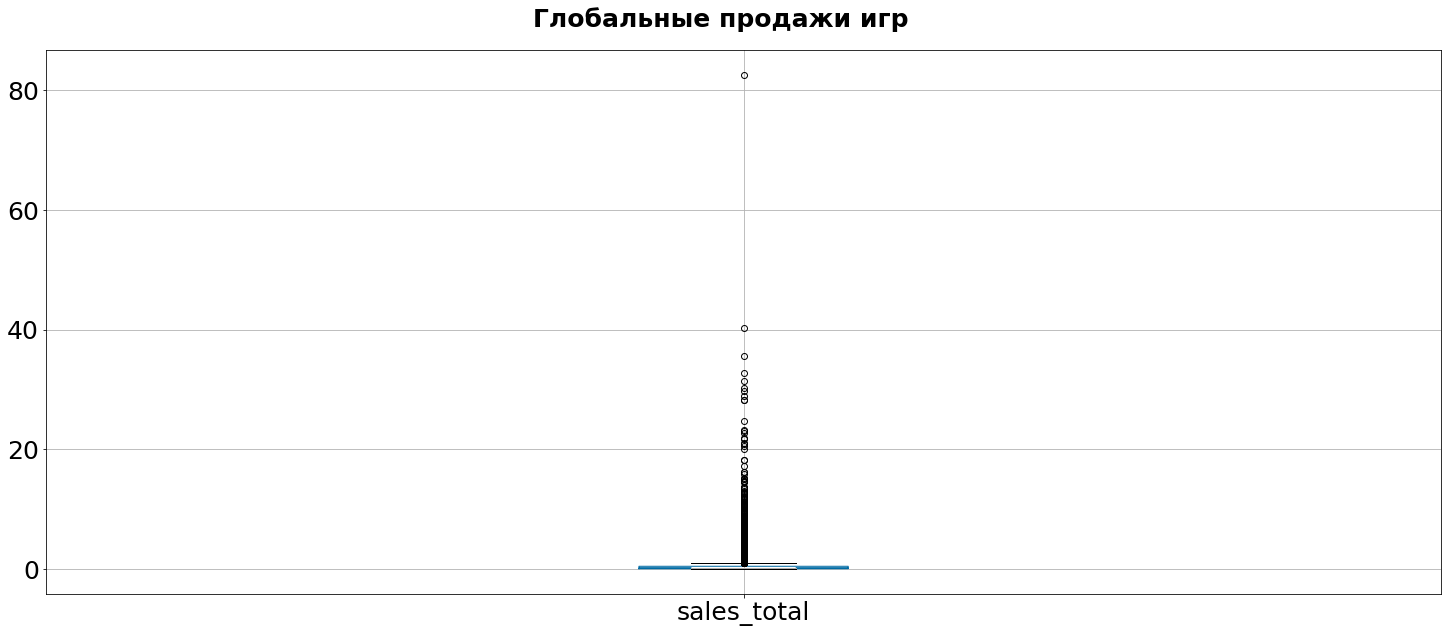

In [27]:
create_any_sales_boxplot('Глобальные продажи игр')

Посмотрим поближе.

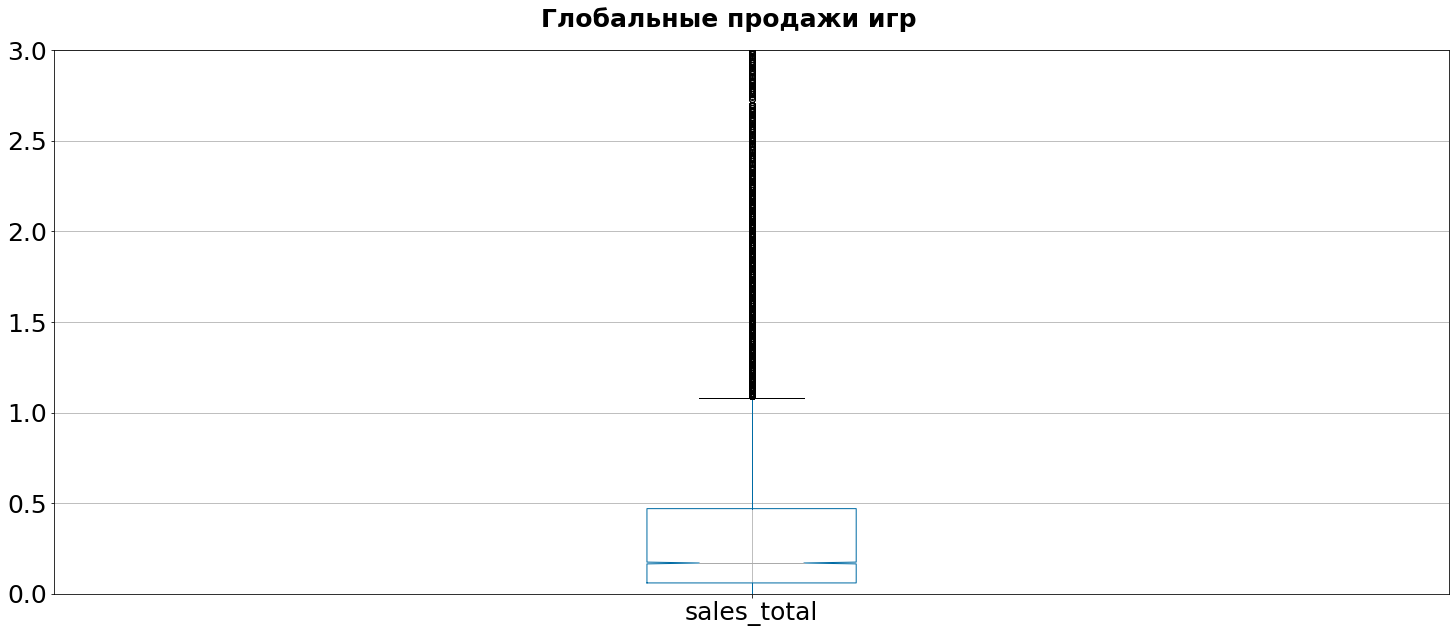

In [28]:
create_any_sales_boxplot('Глобальные продажи игр', ylims = [0, 3])

Средние продажи видеоигры - 1,2 млн долларов.

Медиана - 0,2 миллиона долларов.

Теперь построим boxplot по самым популярным платформам.

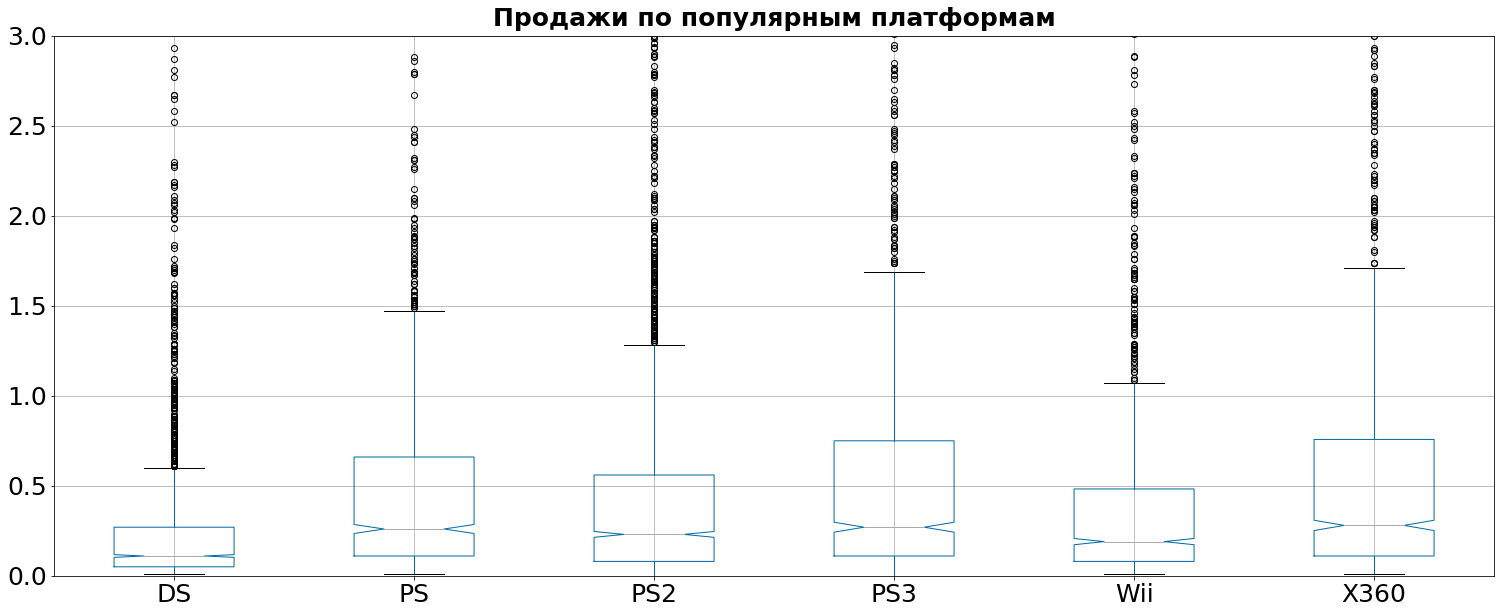

In [29]:
top_platforms = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']
create_any_sales_boxplot('Продажи по популярным платформам', query_condition="platform in @top_platforms", ylims=[0,3])

- DS - медиана - 0.1 млн. долларов. Верхняя граница аномалий - 0.6 млн. долларов.
- PS - медиана - 0.2 млн. долларов. Верхняя граница аномалий - 1.5 млн. долларов.
- PS2 - медиана - 0.2 млн. долларов. Верхняя граница аномалий - 1.3 млн. долларов.
- PS3 - медиана - 0.2 млн. долларов. Верхняя граница аномалий - 1.7 млн. долларов.
- Wii - медиана - 0.2 млн. долларов. Верхняя граница аномалий - 1.2 млн. долларов.
- Xbox 360 - медиана - 0.2 млн. долларов. Верхняя граница аномалий - 1.7 млн. долларов.


<font color=#008000> 3.5 Влияние отзывов на продажи.</font>

Посчитаем влияние отзывов на примере Xbox 360. Это самая первая платформа седьмого поколения.

In [30]:
games_xbox360 = games[(games['platform'] == 'X360') & (games['critic_score'] > 0)].copy()

Построим диаграмму рассеяния зависимости продаж от отзывов критиков.

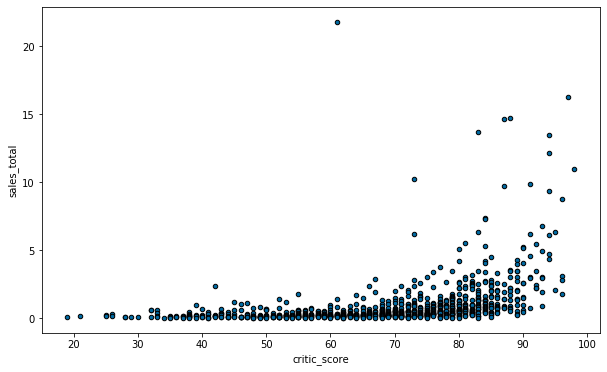

In [31]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

games_xbox360 = games[(games['platform'] == 'X360') & (games['critic_score'] > 0)].copy()
games_xbox360.plot(kind='scatter', x='critic_score', y='sales_total', ec='black', figsize=(10,6))

Чем больше рейтинг игры, тем выше продажи.

Теперь посмотрим на рейтинг от пользователей.

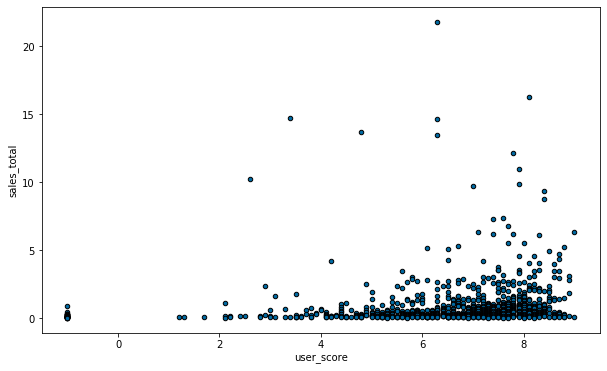

In [32]:
games_xbox360 = games[(games['platform'] == 'X360') & (games['critic_score'] > 0)].copy()
games_xbox360.plot(kind='scatter', x='user_score', y='sales_total', ec='black', figsize=(10,6))

Результат очень похож на предыдущий: чем выше рейтинг, тем выше продажи. Но также в этой диаграмме есть аномалии - игры с низки рейтингом от игроков, но высокими продажами. Причины?

- Критики зачастую получают ревью-копию игры до её официального выхода. Игра получает оценку до или в день начала продаж. Игроки, увидев высокую оценку критиков, ломятся в магазин за свежим релизом, обеспечивая высокие продажи. Но поиграв и оценив игру, они получают негативное впечатление, и выражают своё недовольство ставя низкую оценку. Пример из реальной жизни: "Call of Duty: Modern Warfare (2019)", получившая от критиков в среднем 8 баллов, но имеющая user_score 3.7.

- Игроки зачастую выражают своё недовольство политикой и действиями игровых разработчиков/издателей, ставя низкие оценки их играм. Пример: "Company of Heroes 2", получившая очень низкие оценки от игроков с пост-советского пространства, недовольных тем, как разработчики изобразили в игре советских солдат;

Теперь проверим зависимость продаж от оценки критиков/игроков с помощью матрицы корреляции.

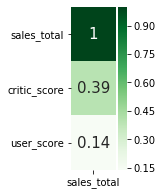

In [33]:
games_xbox360_score = games_xbox360[['sales_total' ,'critic_score', 'user_score']]
plt.figure(figsize=(1,3))
sns.heatmap(games_xbox360_score.corr()[['sales_total']].sort_values(by='sales_total', ascending=False), cmap="Greens", 
            annot=True, annot_kws={'size':15})

Сильнее всего на продажи влияет оценка от критиков, т.к. у них, благодаря ревью-копиям игр, есть возможность поиграть в игры до их релиза. У игры уже в день начала продаж есть оценка, на которую обращают внимание потенциальные покупатели. Игроки же смогут поставить оценку только после начала продаж.

Проверим зависимость продаж от оценки критиков/игроков с помощью матрицы корреляции на разных платформах.

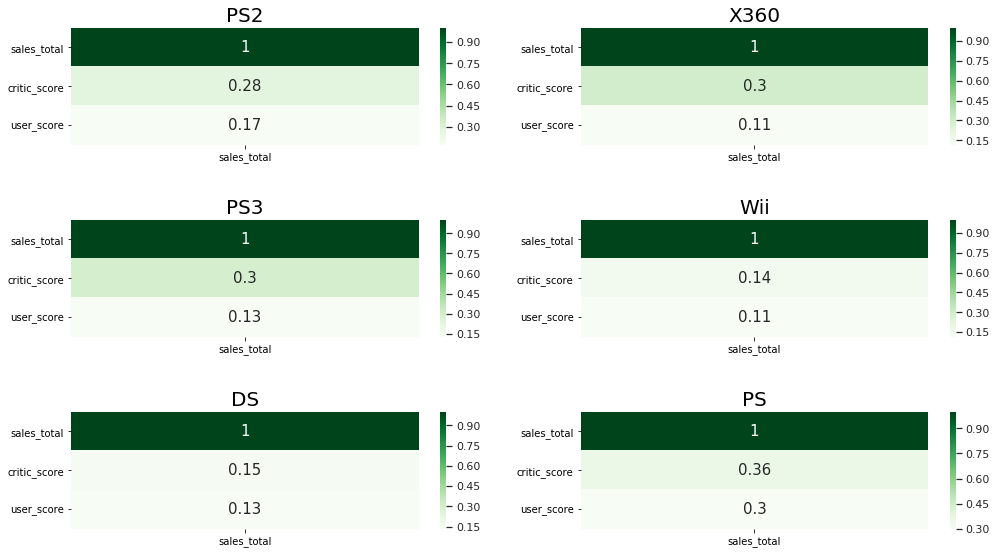

In [34]:
rows = len(top_platforms) // 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(15,8.5))
count = 0
for r in range(rows):
    for c in range(cols):
        curr_platform = top_platforms[count]
        df_prep = games[(games['platform'] == curr_platform) & (games['user_score'] > 0)].copy()
        
        df_filtered = df_prep[['sales_total' ,'critic_score', 'user_score']]
        sns.set(font_scale=1.0)
        ax = sns.heatmap(df_filtered.corr()[['sales_total']].sort_values(by='sales_total', ascending=False), 
                         cmap="Greens", annot=True, annot_kws={'size':15}, ax=axes[r,c])
        ax.set_title(curr_platform, fontsize=20)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        plt.tight_layout(pad=3)
        count += 1

Данные по кореляции для PS, PS2, PS3 и Xbox 360 примерно совпадают с общими данными. Выделяются только консоли производства Nintendo: Wii и DS.


<font color=#008000> 3.6 Распределение игр по жанрам.</font>

Построим столбчатую диаграмму для игровых жанров.

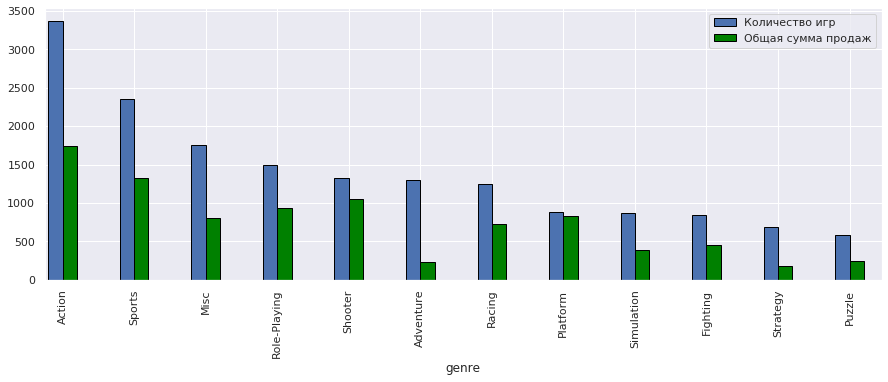

In [35]:
ax = plt.gca()

pivot = games.groupby('genre').agg({'name': 'count', 'sales_total': 'sum'}).sort_values(by='name', ascending=False)

plot1 = pivot['name']
plot1.plot(kind='bar', figsize=(15,5), ec='black', ax=ax, width=0.2, position=1)

plot2 = pivot['sales_total']
plot2.plot(kind='bar', figsize=(15,5), ec='black', ax=ax, width=0.2, color='#008000', position=0)

ax.legend(['Количество игр', 'Общая сумма продаж'])

По количеству игр лидируют жанры:
- Action - быстрый и увлекательный геймплей. Вот что делает этот жанр популярным у аудитории. Популярность подталкивает разработчиков выпускать больше игр этого жанра.
- Sports
- Miscellaneous

Самые нераспространённые жанры:
- Puzzle - этот жанр лучше чувствует себя на мобильных устройствах, чем на домашних консолях.
- Strategy - жанр почти полностью экслюзивен для платформы PC.
- Fighting - есть всего несколько очень популярных серий игр, причисляемых к этому жанру: Mortal Kombat, Street Fighter, Guilty Gear, Tekken, Super Smash Bros. Это сказывается на общем количестве вышедших игр.

По продажам лидируют:
- Action - опять же, увлекательный геймплей = высокие продажи.
- Sports - игры серии FIFA, Madden выходят каждый год, и приносят бешенные деньги издателям.
- Shooter - увлекательный геймплей = высокие продажи.

Самые низкие продажи:
- Strategy - этот жанр уже давно находится в упадке;
- Adventure
- Puzzle - этот жанр лучше чувствует себя на мобильных устройствах, чем на домашних консолях.


###### Вывод 3

- посчитали, сколько игр выпускалось в разные годы;
- определили среднюю продолжительность жизни платформы - 10 лет;
- определили наиболее перспективные платформы на 2017 год: PS4, Xbox One и 3DS;
- определили, что продажи сильнее зависят от оценки критиков, чем от оценки игроков;
- определили самые распространённые жанры: Action, Sports, Miscellaneous;
- Определили самые доходные жанры: Action, Sports, Shooter;

# Шаг 4. Портрет пользователя каждого региона

У нас есть данные по продажам из трёх регионов:
- Северная Америка (NA)
- Европа (EU)
- Япония (JP)

Найдём самые популярные платформы и жанры для каждого региона, а также определим зависимость продаж от рейтинга ESRB.

<font color=#008000> 4.1 Топ-5 платформ в каждом регионе.</font>

In [55]:
def most_popular_plot(groupby, region_sales, ax):
    title_dict = {'na_sales' : 'Продажи в Северной Америке', 
                  'eu_sales' : 'Продажи в Европе', 
                  'jp_sales' : 'Продажи в Японии'}
    color_dict = {'na_sales': 'blue', 'eu_sales': 'gray', 'jp_sales': 'forestgreen'}
    games_filtered = games.groupby(groupby).agg({region_sales: 'sum'}).sort_values(by = region_sales, ascending = False)[:5]
    plot = games_filtered.plot(kind = 'bar', ec = 'black', title = title_dict[region_sales], ax = axes[ax], 
                   fontsize = 18, color = color_dict[region_sales], rot = 20)
    plot.legend(prop={'size':17})
    plot.set_xlabel('')
    plot.title.set_size(20)

<IPython.core.display.Javascript object>


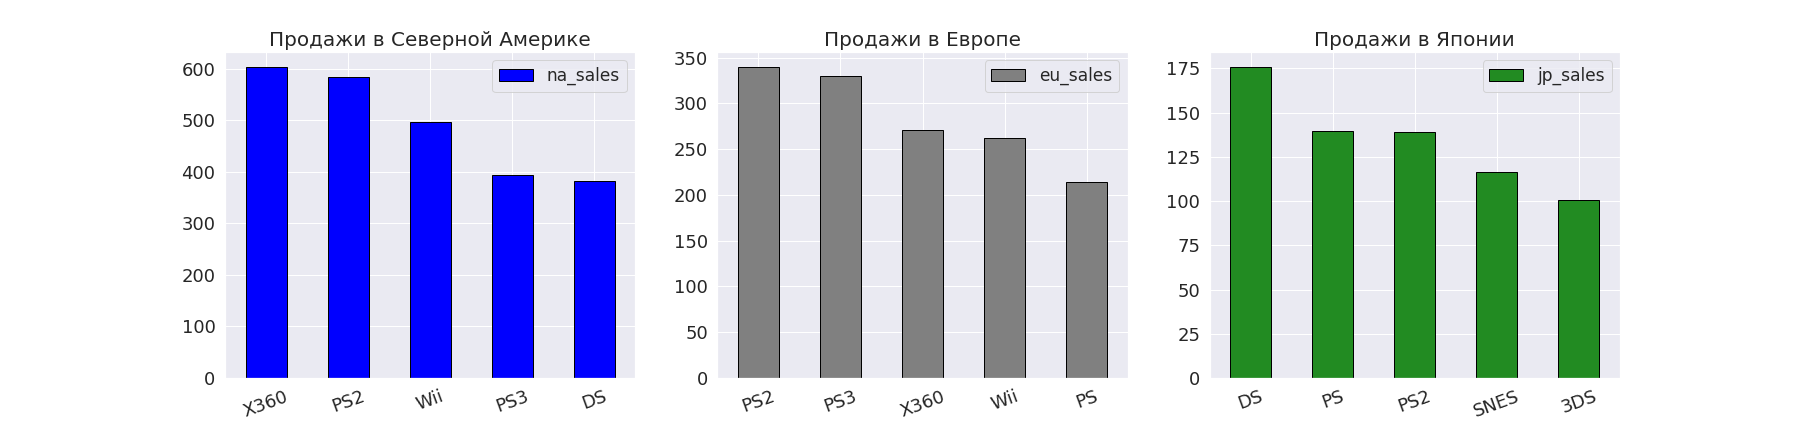

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

most_popular_plot('platform', 'na_sales', 0)
most_popular_plot('platform', 'eu_sales', 1)
most_popular_plot('platform', 'jp_sales', 2)

1) В Северной Америкие среди платформ лидирует Xbox360. Он вышел в ноябре 2005 году, на целый год раньше своего главного конкурента по поколению - PS3. Это позволило Xbox360 закрепится на рыке. За ним следует PS2, Wii, PS3 и Nintendo DS.

2) В Европе самыми популярными платформали оказались PS2 и PS3. За ними следует с почти одинаковыми результатами Xbox360 и Wii. Замыкает 5ку - PS.

3) В японии лидирует DS, затем с идентичными результатами PS и PS3, далее SNES, и замыкает 5ку 3DS. Xbox 360 не попал в топ-5. Платформе Microsoft не удалось закрепится на японском рынке, из-за отсутствия на платформе ориентированных на японцев игр.

<font color=#008000> 4.2 Топ-5 жанров в каждом регионе.</font>

<IPython.core.display.Javascript object>


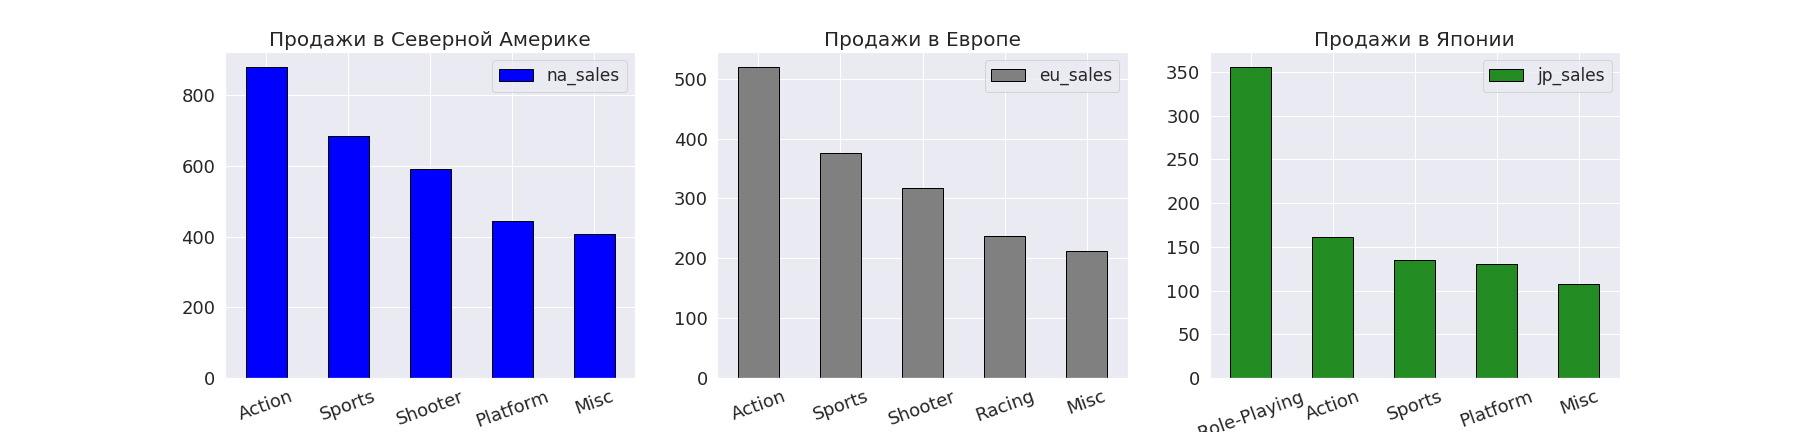

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

most_popular_plot('genre', 'na_sales', 0)
most_popular_plot('genre', 'eu_sales', 1)
most_popular_plot('genre', 'jp_sales', 2)

1) В Северной Америкие среди жанров лидируют Action, Sports, Shooter, Platform и Misc.

2) В Европе результаты схожи с Северной Америкой: Action, Sports, Shooter, Racing и Misc.

3) Самый популярный жанр игр в Японии - JRPG. Xbox 360 не пользовался популярностью именно из-за малого количества игр этого жанра. За RPG следует Action, Sports, Platform и Misc.

<font color=#008000> 4.3 Влияние рейтинга ESRB на продажи в отдельном регионе.</font>

Нужно определить влияние рейтинга ESRB на продажи в каждом регионе. Для начала посмотрим, какие рейтинги присутствуют у нас в таблице.

In [58]:
games['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

- E - Everyone (Для всех)
- M - Mature (Старше 17 лет)
- T - Teen (Для подростков от 13 лет)
- E10+ - Everyone 10+ (Для всех от 10 лет)
- K-A - Kids to Adults (Для детей и взрослых). Устаревший рейтинг, заменённый рейтингом E.
- AO - Adults Only (Только для взрослых от 18 лет)
- EC - Early Childhood (Для детей младшего возраста)
- RP - Rating Pending (В ожидании оценки). Заплатка, означающая, что игра ещё не получила оценку ESRB.

Рейтинг K-A лучше заменить на современный E.

In [59]:
games['rating'] = games['rating'].replace('K-A', 'E')

Теперь посмотрим, как рейтинг влияет на продажи игр.

<IPython.core.display.Javascript object>


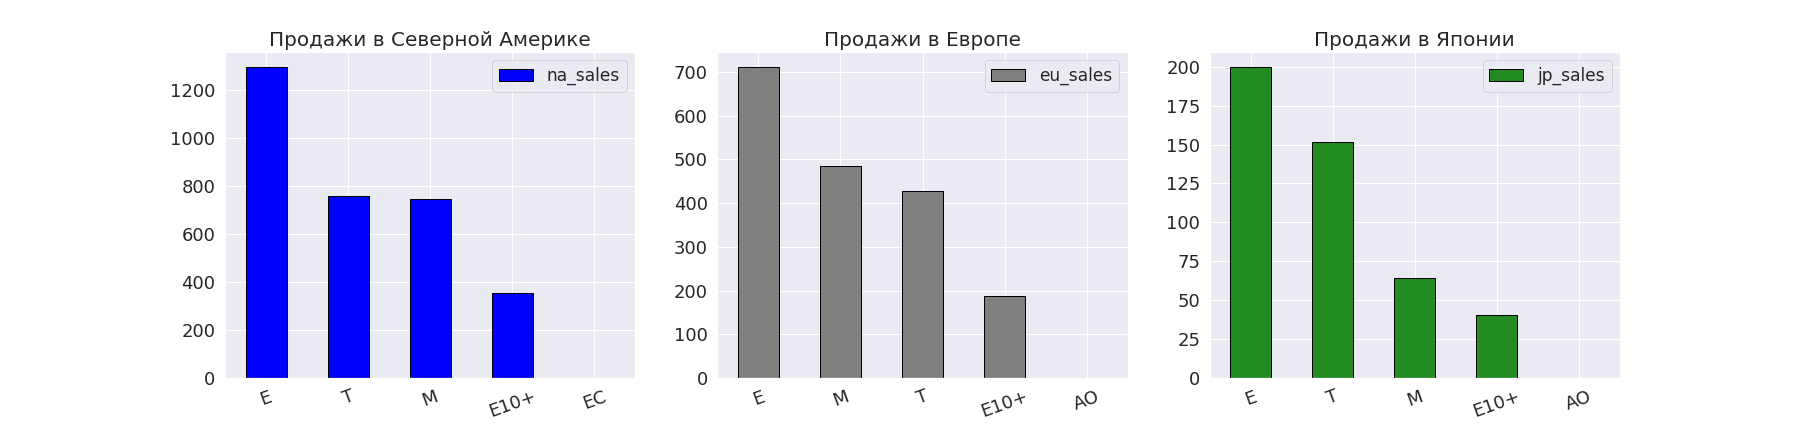

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

most_popular_plot('rating', 'na_sales', 0)
most_popular_plot('rating', 'eu_sales', 1)
most_popular_plot('rating', 'jp_sales', 2)

- В Северной Америке по продажам лидируют игры с рейтингом E (Для Всех). Далее с почти идентичными результатами идут игры с рейтингами T (от 13 лет) и M (от 17 лет). На 4 месте игры E10+ (от 10 лет). На последнем месте игры для дошкольников.
- В Европе игры с рейтином M (от 17 лет) популярнее игр с рейтингом T (от 13 лет). На пятой позиции AO (Только для взрослых).
- В Японии игры с рейтингом T (от 13 лет) намного популярнее игр с рейтингом M (от 17 лет).

###### Вывод 4

Мы сравнили данные по регионам NA, EU и JP.

Топ-5 платформ по регионам:
- Северная Америка - Xbox360, PS2, Wii, PS3, DS.
- Европа - PS2, PS3, Xbox360, Wii, PS.
- Япония - DS, PS, PS3, SNES, 3DS.

Топ-5 жанров по регионам:
- Северная Америка - Action, Sports, Shooter, Platform, Misc.
- Европа - Action, Sports, Shooter, Racing, Misc.
- Япония - RPG, Action, Sports, Platform, Misc.

Игры с каким рейтингом продаются лучше в каждом регионе:
- Северная Америка - E, T, M, E10+, EC.
- Европа - E, M, T, E10+, AO.
- Япония - E, T, M, E10+, AO.


# Шаг 5. Проверьте гипотезы

- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
- Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.

<font color=#008000> 5.1 Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.</font>

Сформулируем нулевую и альтернативную гипотезы.
- "Нулевая гипотеза" - средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
- "Альтернативная гипотеза" - средние пользовательские рейтинги платформ Xbox One и PC различаются.

Пороговым значением установим 0.05

Посчитаем средний пользовательский рейтинг для платформ Xbox One и PC.

In [76]:
xbox_one_user_score = games[(games['platform'] == 'XOne') & (games['user_score'] > 0)]['user_score']
pc_user_score = games[(games['platform'] == 'PC') & (games['user_score'] > 0)]['user_score']

stat, p = ttest_ind(xbox_one_user_score, pc_user_score)

print('t = {}\np-value = {:.10e}'.format(stat, p))

t = -4.368333815003015
p-value = 1.3896435534e-05


Нулевая гипотеза отклонена. Средние пользовательские рейтинги платформ Xbox One и PC различаются

In [67]:
print('Средняя пользовательская оценка игр для Xbox One: {:.2f}'.format(xbox_one_user_score.mean()))

Средняя пользовательская оценка игр для Xbox One: 6.52


In [68]:
print('Средняя пользовательская оценка игр для PC: {:.2f}'.format(pc_user_score.mean()))

Средняя пользовательская оценка игр для PC: 7.06


<font color=#008000> 5.2 Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.</font>

Сформулируем нулевую и альтернативную гипотезы.
- "Нулевая гипотеза" - пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») одинаковые.
- "Альтернативная гипотеза" - пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») различаются.

Пороговым значением установим 0.05

Посчитаем средний пользовательский рейтинг для жанров Action (англ. «действие») и Sports (англ. «виды спорта»).

In [77]:
action_user_score = games[(games['genre'] == 'Action') & (games['user_score'] > 0)]['user_score']
sports_user_score = games[(games['genre'] == 'Sports') & (games['user_score'] > 0)]['user_score']

stat, p = ttest_ind(action_user_score, sports_user_score)

print('t = {}\np-value = {:.10e}'.format(stat, p))

t = 1.6259419280500857
p-value = 1.0406951359e-01


Нулевая гипотеза подтверждена. Пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») одинаковые.

###### Вывод 5

Мы проверили 2 гипотезы, и пришли к следующим выводам:

Гипотеза 1 - "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые" - отклонена.

Гипотеза 2 - "Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные" - подтверждена.


# Шаг 6. Общий вывод

<font color=#800080>Осмотрев предоставленные нам данны мы нашли следующие ошибки:</font>
- В колонке 'User_Score' тип данных object. Заменим его на float.
- В колонках 'Name', 'Year_of_Release', 'Genre', 'Critic_Score', 'User_Score' и 'Rating' есть пропуски. В 'Name' и 'Genre' их по два (возможно есть связь).
- Названия колонок начинаются с загланой буквы. С ними очень неудобно работать. Нужно будет перевести в нижний регистр.

<font color=#800080>Для подготовки данных к анализу мы произвели следующие действия:</font>
- перевели названия колонок в нижний регистр.
- перевели данные в 'user_score' из object в float.
- заменили пропуски в 'critic_score' и 'user_score' на значение -1.
- удалили строчки с пропусками в колонках 'name' и 'genre'.

<font color=#800080>Исследование данных включадо следующие действия:</font>
- посчитали, сколько игр выпускалось в разные годы;
- определили среднюю продолжительность жизни платформы - 10 лет;
- определили наиболее перспективные платформы на 2017 год: PS4, Xbox One и 3DS;
- определили, что продажи сильнее зависят от оценки критиков, чем от оценки игроков;
- определили самые распространённые жанры: Action, Sports, Miscellaneous;
- Определили самые доходные жанры: Action, Sports, Shooter;

<font color=#800080>Мы описали среднестатистические предпочтения игроков из 3х регионов:</font>

Топ-5 платформ по регионам:
- Северная Америка - Xbox360, PS2, Wii, PS3, DS.
- Европа - PS2, PS3, Xbox360, Wii, PS.
- Япония - DS, PS, PS3, SNES, 3DS.

Топ-5 жанров по регионам:
- Северная Америка - Action, Sports, Shooter, Platform, Misc.
- Европа - Action, Sports, Shooter, Racing, Misc.
- Япония - RPG, Action, Sports, Platform, Misc.

Игры с каким рейтингом продаются лучше в каждом регионе:
- Северная Америка - E, T, M, E10+, EC.
- Европа - E, M, T, E10+, AO.
- Япония - E, T, M, E10+, AO.


<font color=#800080>Мы проверили 2 гипотезы, и пришли к следующим выводам:</font>

Гипотеза 1 - "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые" - отклонена.

Гипотеза 2 - "Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные" - подтверждена.